In [1]:
import os; os.environ["CONDA_PREFIX"] = "/opt/conda"
!pip install -U -q uv

In [2]:
!uv pip install modAL-python torchvision torchmetrics mlxtend torchsummary scikit-learn-intelex

Resolved 46 packages in 1.04s
Downloaded 15 packages in 1.27s
Installed 15 packages in 116ms
 - contourpy==1.2.0
 - contourpy==1.2.1 (from file:///home/conda/feedstock_root/build_artifacts/contourpy_1712429905637/work)
 + contourpy==1.2.0
 - fonttools==4.47.0
 - fonttools==4.51.0 (from file:///home/conda/feedstock_root/build_artifacts/fonttools_1712344558731/work)
 + fonttools==4.47.0
 - fsspec==2024.2.0
 - fsspec==2024.3.1 (from file:///home/conda/feedstock_root/build_artifacts/fsspec_1710808267764/work)
 + fsspec==2024.2.0
 - markupsafe==2.1.5
 - markupsafe==2.1.3 (from file:///home/conda/feedstock_root/build_artifacts/markupsafe_1695367434228/work)
 + markupsafe==2.1.5
 - matplotlib==3.7.5
 - matplotlib==3.8.4 (from file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1712605966339/work)
 + matplotlib==3.7.5
 + modal-python==0.4.2.1
 - pandas==2.1.4
 - pandas==2.2.2
 + pandas==2.2.2
 - pillow==9.5.0
 - pillow==10.3.0 (from file:///home/conda/feedstock_root/build_artifa

# Imports

In [3]:
import random
from pathlib import Path
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import requests
import torch
import torchvision
import torchvision.models as models
from mlxtend.plotting import plot_confusion_matrix
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from skorch import NeuralNetClassifier
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix, F1Score, Precision, Recall
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from sklearnex import patch_sklearn
import warnings
from sklearn.linear_model import LogisticRegression
import tensorflow_hub as hub
from datasets import load_dataset
import pandas as pd

os.mkdir('reports')
patch_sklearn()
print(f"mlxtend version: {mlxtend.__version__}")
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

2024-05-02 00:51:36.771515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 00:51:36.771611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 00:51:36.908944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


mlxtend version: 0.23.1
torch 2.1.2
torchvision 0.16.2
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# FashionMNIST


In [4]:
FashionMNIST_train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
FashionMNIST_test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)

x_train, y_train = FashionMNIST_train_data.data, np.array(FashionMNIST_train_data.targets)
x_test, y_test = FashionMNIST_test_data.data, np.array(FashionMNIST_test_data.targets)

100%|██████████| 26421880/26421880 [00:15<00:00, 1759120.64it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 105478.18it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 466506.84it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11107138.37it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 28, 28]), (60000,), torch.Size([10000, 28, 28]), (10000,))

In [7]:
FashionMNIST_class_names = FashionMNIST_train_data.classes
print(FashionMNIST_class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
num_classes = len(FashionMNIST_class_names)
num_classes

10

In [9]:
class_to_idx_cif = FashionMNIST_train_data.class_to_idx
print(class_to_idx_cif)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


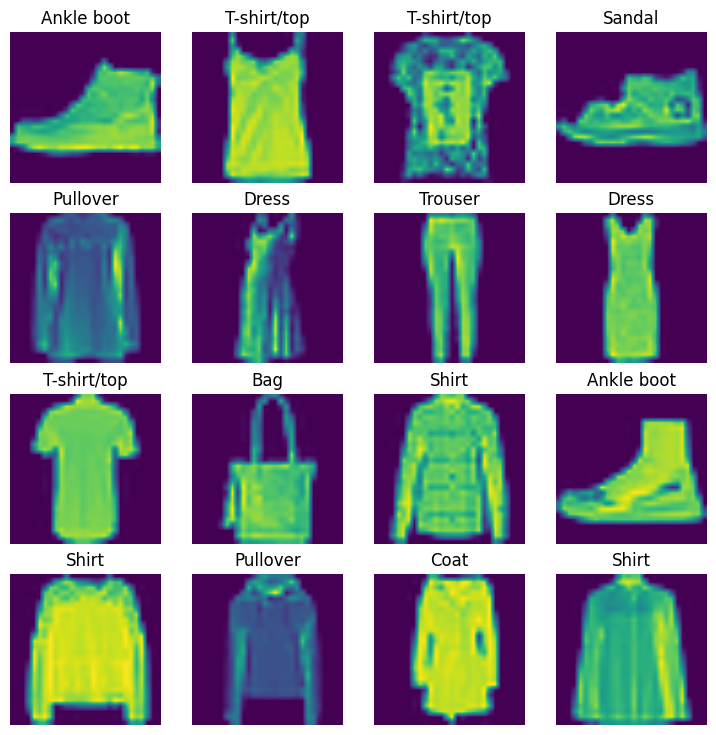

<Figure size 640x480 with 0 Axes>

In [10]:
# Show more images
plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_index = torch.randint(1, len(FashionMNIST_train_data), size=[1]).item()
    plt.subplot(rows, cols, i)
    image, label = FashionMNIST_train_data[random_index]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image, interpolation="bilinear")
    plt.title(FashionMNIST_class_names[label])
    plt.axis(False)

plt.show()
plt.savefig("reports/FashionMNIST_imgs_labeled.png")

# Unlabeling The Dataset

In [11]:
# Define the percentage of data without labels
percentage_without_labels = 0.8

# Calculate the number of samples without labels
num_samples_without_labels = int(len(FashionMNIST_train_data) * percentage_without_labels)
num_samples_with_labels = len(FashionMNIST_train_data) - num_samples_without_labels

# Create indices for data with labels and without labels
indices_without_labels = np.random.choice(range(len(FashionMNIST_train_data)), size=num_samples_without_labels, replace=False)
indices_with_labels = np.array([i for i in range(len(FashionMNIST_train_data)) if i not in indices_without_labels])

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [12]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

(torch.Size([12000, 28, 28]), (12000,), torch.Size([48000, 28, 28]), (48000,))

In [13]:
x_initial.unsqueeze(1).repeat(1, 3, 1, 1).shape

torch.Size([12000, 3, 28, 28])

In [14]:
len(FashionMNIST_train_data)

60000

In [15]:
FashionMNIST_train_data[1][1]

0

# Creating the DataLoaders


In [16]:
def numpy_to_dataloader(x, y, batch_size=32):
    dataset = torch.utils.data.TensorDataset(torch.tensor(x, dtype=torch.float32).unsqueeze(1).repeat(1, 3, 1, 1), torch.tensor(y))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
BATCH_SIZE_CIF = 32

FashionMNIST_train_data_loader = numpy_to_dataloader(x_initial, y_initial, BATCH_SIZE_CIF)
FashionMNIST_test_data_loader = numpy_to_dataloader(x_test, y_test, BATCH_SIZE_CIF)

In [18]:
FashionMNIST_train_data_loader, FashionMNIST_test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x79bfed46f700>,
 <torch.utils.data.dataloader.DataLoader at 0x79c13135bfa0>)

In [19]:
print(f"Length of Training Data loader: {len(FashionMNIST_train_data_loader)}, Batches of {FashionMNIST_train_data_loader.batch_size}")
print(f"Length of Testing Data loader: {len(FashionMNIST_test_data_loader)}, Batches of {FashionMNIST_test_data_loader.batch_size}")

Length of Training Data loader: 375, Batches of 32
Length of Testing Data loader: 313, Batches of 32


# Importing and Using ResNet 50 Architecture


In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [21]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
next(model.parameters()).device

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


device(type='cpu')

In [22]:
f = nn.Flatten(start_dim=0)  # The default start dim is 1
x = f(torch.randn(10, 7, 7))
x.size()

torch.Size([490])

In [23]:
rand_image_tensor = torch.randn(size=(32, 3, 28, 28))

In [24]:
rand_image_tensor.device

device(type='cpu')

In [25]:
model(rand_image_tensor)

tensor([[-2.4055e-01, -6.9355e-01,  5.1512e-02, -1.4307e-01, -4.5316e-01,
         -3.9759e-01, -1.0348e+00, -5.3284e-02, -5.6661e-01,  7.3980e-03],
        [-2.5328e-01, -4.5026e-02,  2.3577e-01, -2.4327e-02,  6.2012e-02,
          4.0527e-01,  2.8294e-01,  5.6737e-01,  3.0373e-02,  1.4588e-02],
        [ 6.9605e-02, -3.5973e-01,  7.9209e-01, -6.0697e-01,  1.1925e-01,
         -2.8521e-01, -8.4031e-03,  6.9729e-01, -2.3646e-01,  4.1388e-01],
        [-3.6931e-01,  4.3285e-01, -7.4615e-02, -1.2246e-01,  5.7829e-02,
          4.3866e-01, -5.8185e-02, -8.7363e-02, -1.2631e-01, -3.0405e-01],
        [ 4.8175e-01,  1.1296e-01,  6.0873e-01, -1.2846e+00,  6.9586e-01,
         -3.4212e-01,  7.5203e-01,  5.8188e-01,  3.0977e-01, -7.9993e-01],
        [ 3.1832e-01, -2.1656e-01,  4.6032e-01, -6.4490e-01,  1.4218e-01,
          4.2469e-01, -3.0811e-01,  5.7091e-01, -2.5584e-01,  5.6486e-01],
        [-9.4574e-01, -3.9894e-03,  5.2894e-02, -1.1238e+00,  5.5720e-01,
          2.6480e-01, -2.3859e-0

In [26]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

# Printing the Architecture and Number of Trianing Parameters in each Layer


In [27]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

# External Helper Functions


In [28]:
if Path("HelperFunctions.py").is_file():
    print("Helper Functions already exists, skipping downloading")
else:
    print("downloading HelperFunctions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("HelperFunctions.py", "wb") as f:
        f.write(request.content)

downloading HelperFunctions.py


In [29]:
# Picking a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [30]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = correct / len(y_true) * 100
    return accuracy

In [31]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")
    return total_time

In [32]:
start = timer()
end = timer()
display_train_time(start, end, device="cpu")

Train time on device cpu: 0.000 seconds


2.5079000124605955e-05

In [33]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    training_loss = 0
    training_acc = 0
    model.train()

    for batch, (x, y) in enumerate(data_loader):
        # Put the data on the target device
        x, y = x.to(device), y.to(device)
        # Forward Pass
        y_pred = model(x)
        # Loss
        loss = loss_fn(y_pred, y)
        training_loss += loss
        training_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss Backward
        loss.backward()
        # optimizer step step step
        optimizer.step()
    # After looping over batches, divide the training loss over the number of batches to get the average loss per batch
    training_loss /= len(
        data_loader
    )  # train.data_loader (returns the number of batches)
    training_acc /= len(data_loader)
    print(f"Training Loss: {training_loss:.5f} | Training Accuracy: {training_acc:.2f}%")
    return training_acc, training_loss

In [34]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    testing_acc = 0
    testing_loss = 0
    model.eval()

    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_test_pred = model(x)
            # Loss
            testing_loss += loss_fn(y_test_pred, y)
            # Accuracy
            testing_acc += accuracy_fn(y_test_pred.argmax(dim=1), y)
        testing_loss /= len(data_loader)
        testing_acc /= len(data_loader)
    print(f"Testing Loss: {testing_loss:.3f} | Testing Accuracy: {testing_acc:.2f}%")
    return testing_acc, testing_loss

In [35]:
# Initialize precision, recall, and F1 score metrics
precision = Precision(task="multiclass", num_classes=num_classes)
recall = Recall(task="multiclass", num_classes=num_classes)
f1 = F1Score(task="multiclass", num_classes=num_classes)
confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

# Base Model Training

In [36]:
# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_start_time_on_gpu = timer()
# Set the number of epochs
epochs = 50
acc_TRAIN = []
acc_TEST = []
loss_TRAIN = []
loss_TEST = []
precision_result = []
recall_result = []
f1_result = []
# Training
for epoch in tqdm(range(epochs)):
    print(f"\nepoch: {epoch+1}\n--------------------------------------")
    ACC_TRAIN = 0
    LOSS_TRAIN = 0
    ACC_TEST = 0
    LOSS_TEST = 0
    # Training
    ACC_TRAIN, LOSS_TRAIN = train_step(model, FashionMNIST_train_data_loader, loss_fn, optimizer, accuracy_fn, device)
    # Testing
    ACC_TEST, LOSS_TEST = test_step(model, FashionMNIST_test_data_loader, loss_fn, accuracy_fn, device)
    # y_preds
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for x, y in tqdm(FashionMNIST_test_data_loader, desc="Making Predictions..."):
            # Send the data to the target device
            x, y = x.to(device), y.to(device)
            # Forward Pass
            logits = model(x)
            # Pred probs then labels
            y_pred = torch.softmax(logits, dim=1).argmax(dim=1)
            # Put predictions on the cpu for evaluation
            y_preds.append(y_pred.cpu())
    # Concatenate the predicions of all batches
    y_pred_tensor = torch.cat(y_preds)
    # Update the metrics with true and predicted labels
    precision.update(y_pred_tensor, torch.tensor(FashionMNIST_test_data.targets))
    recall.update(y_pred_tensor, torch.tensor(FashionMNIST_test_data.targets))
    f1.update(y_pred_tensor, torch.tensor(FashionMNIST_test_data.targets))
    # List
    acc_TRAIN.append(ACC_TRAIN)
    acc_TEST.append(ACC_TEST)
    loss_TRAIN.append(LOSS_TRAIN.detach().cpu().numpy())
    loss_TEST.append(LOSS_TEST.detach().cpu().numpy())
    precision_result.append(precision.compute())
    recall_result.append(recall.compute())
    f1_result.append(f1.compute())
    
# Compute the time of the training
print("\nTraining is finished!\n")
train_end_time_on_gpu = timer()
display_train_time(
    train_start_time_on_gpu,
    train_end_time_on_gpu,
    device=next(model.parameters()).device,
)

  0%|          | 0/50 [00:00<?, ?it/s]


epoch: 1
--------------------------------------
Training Loss: 1.57334 | Training Accuracy: 51.91%
Testing Loss: 0.815 | Testing Accuracy: 68.51%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 2
--------------------------------------
Training Loss: 0.87362 | Training Accuracy: 68.99%
Testing Loss: 0.649 | Testing Accuracy: 75.69%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 3
--------------------------------------
Training Loss: 0.61961 | Training Accuracy: 76.99%
Testing Loss: 1.028 | Testing Accuracy: 77.04%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 4
--------------------------------------
Training Loss: 0.55689 | Training Accuracy: 79.78%
Testing Loss: 1.027 | Testing Accuracy: 79.56%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 5
--------------------------------------
Training Loss: 0.49309 | Training Accuracy: 81.92%
Testing Loss: 1.550 | Testing Accuracy: 80.51%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 6
--------------------------------------
Training Loss: 0.49466 | Training Accuracy: 81.90%
Testing Loss: 3.769 | Testing Accuracy: 73.32%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 7
--------------------------------------
Training Loss: 0.46428 | Training Accuracy: 82.74%
Testing Loss: 0.420 | Testing Accuracy: 84.09%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 8
--------------------------------------
Training Loss: 0.43936 | Training Accuracy: 83.56%
Testing Loss: 0.461 | Testing Accuracy: 83.80%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 9
--------------------------------------
Training Loss: 0.41024 | Training Accuracy: 84.61%
Testing Loss: 0.475 | Testing Accuracy: 82.25%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 10
--------------------------------------
Training Loss: 0.38526 | Training Accuracy: 85.52%
Testing Loss: 0.411 | Testing Accuracy: 84.42%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 11
--------------------------------------
Training Loss: 0.38178 | Training Accuracy: 85.64%
Testing Loss: 0.456 | Testing Accuracy: 81.35%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 12
--------------------------------------
Training Loss: 0.37486 | Training Accuracy: 86.14%
Testing Loss: 0.423 | Testing Accuracy: 83.77%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 13
--------------------------------------
Training Loss: 0.36268 | Training Accuracy: 86.87%
Testing Loss: 0.444 | Testing Accuracy: 84.22%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 14
--------------------------------------
Training Loss: 0.36017 | Training Accuracy: 86.38%
Testing Loss: 0.477 | Testing Accuracy: 83.19%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 15
--------------------------------------
Training Loss: 0.35585 | Training Accuracy: 86.85%
Testing Loss: 0.407 | Testing Accuracy: 85.13%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 16
--------------------------------------
Training Loss: 0.34984 | Training Accuracy: 87.13%
Testing Loss: 0.420 | Testing Accuracy: 84.94%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 17
--------------------------------------
Training Loss: 0.32999 | Training Accuracy: 87.83%
Testing Loss: 0.393 | Testing Accuracy: 85.87%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 18
--------------------------------------
Training Loss: 0.33009 | Training Accuracy: 87.37%
Testing Loss: 0.373 | Testing Accuracy: 86.46%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 19
--------------------------------------
Training Loss: 0.35000 | Training Accuracy: 87.32%
Testing Loss: 0.595 | Testing Accuracy: 82.04%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 20
--------------------------------------
Training Loss: 0.33500 | Training Accuracy: 87.94%
Testing Loss: 0.377 | Testing Accuracy: 87.26%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 21
--------------------------------------
Training Loss: 0.30484 | Training Accuracy: 88.81%
Testing Loss: 0.429 | Testing Accuracy: 84.89%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 22
--------------------------------------
Training Loss: 0.28667 | Training Accuracy: 89.42%
Testing Loss: 0.371 | Testing Accuracy: 87.16%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 23
--------------------------------------
Training Loss: 0.28639 | Training Accuracy: 89.25%
Testing Loss: 0.442 | Testing Accuracy: 85.13%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 24
--------------------------------------
Training Loss: 0.27534 | Training Accuracy: 89.84%
Testing Loss: 0.411 | Testing Accuracy: 85.13%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 25
--------------------------------------
Training Loss: 0.28152 | Training Accuracy: 89.49%
Testing Loss: 0.416 | Testing Accuracy: 86.39%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 26
--------------------------------------
Training Loss: 0.26517 | Training Accuracy: 90.42%
Testing Loss: 0.379 | Testing Accuracy: 86.97%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 27
--------------------------------------
Training Loss: 0.26596 | Training Accuracy: 90.36%
Testing Loss: 0.396 | Testing Accuracy: 86.06%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 28
--------------------------------------
Training Loss: 0.25318 | Training Accuracy: 90.58%
Testing Loss: 0.403 | Testing Accuracy: 86.49%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 29
--------------------------------------
Training Loss: 0.24162 | Training Accuracy: 91.13%
Testing Loss: 0.380 | Testing Accuracy: 87.33%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 30
--------------------------------------
Training Loss: 0.23509 | Training Accuracy: 91.40%
Testing Loss: 0.374 | Testing Accuracy: 87.08%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 31
--------------------------------------
Training Loss: 0.22950 | Training Accuracy: 91.58%
Testing Loss: 0.377 | Testing Accuracy: 88.04%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 32
--------------------------------------
Training Loss: 0.26395 | Training Accuracy: 90.54%
Testing Loss: 0.398 | Testing Accuracy: 86.75%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 33
--------------------------------------
Training Loss: 0.23476 | Training Accuracy: 91.15%
Testing Loss: 0.383 | Testing Accuracy: 86.53%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 34
--------------------------------------
Training Loss: 0.22337 | Training Accuracy: 91.78%
Testing Loss: 0.413 | Testing Accuracy: 86.76%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 35
--------------------------------------
Training Loss: 0.20480 | Training Accuracy: 92.60%
Testing Loss: 0.408 | Testing Accuracy: 86.64%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 36
--------------------------------------
Training Loss: 0.19406 | Training Accuracy: 92.70%
Testing Loss: 0.387 | Testing Accuracy: 87.72%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 37
--------------------------------------
Training Loss: 0.19122 | Training Accuracy: 92.79%
Testing Loss: 0.394 | Testing Accuracy: 87.22%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 38
--------------------------------------
Training Loss: 0.19980 | Training Accuracy: 92.66%
Testing Loss: 0.378 | Testing Accuracy: 87.64%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 39
--------------------------------------
Training Loss: 0.19173 | Training Accuracy: 93.18%
Testing Loss: 0.385 | Testing Accuracy: 88.03%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 40
--------------------------------------
Training Loss: 0.18635 | Training Accuracy: 93.19%
Testing Loss: 0.413 | Testing Accuracy: 87.90%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 41
--------------------------------------
Training Loss: 0.18207 | Training Accuracy: 93.40%
Testing Loss: 0.426 | Testing Accuracy: 86.90%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 42
--------------------------------------
Training Loss: 0.18083 | Training Accuracy: 93.28%
Testing Loss: 0.555 | Testing Accuracy: 86.50%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 43
--------------------------------------
Training Loss: 0.21423 | Training Accuracy: 92.28%
Testing Loss: 0.401 | Testing Accuracy: 87.62%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 44
--------------------------------------
Training Loss: 0.14214 | Training Accuracy: 94.70%
Testing Loss: 0.451 | Testing Accuracy: 87.30%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 45
--------------------------------------
Training Loss: 0.14193 | Training Accuracy: 94.69%
Testing Loss: 0.475 | Testing Accuracy: 87.12%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 46
--------------------------------------
Training Loss: 0.13071 | Training Accuracy: 95.10%
Testing Loss: 0.452 | Testing Accuracy: 87.51%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 47
--------------------------------------
Training Loss: 0.14059 | Training Accuracy: 94.72%
Testing Loss: 0.442 | Testing Accuracy: 87.88%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 48
--------------------------------------
Training Loss: 0.13898 | Training Accuracy: 94.87%
Testing Loss: 0.489 | Testing Accuracy: 87.73%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 49
--------------------------------------
Training Loss: 0.12730 | Training Accuracy: 95.38%
Testing Loss: 0.465 | Testing Accuracy: 87.05%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


epoch: 50
--------------------------------------
Training Loss: 0.13093 | Training Accuracy: 95.09%
Testing Loss: 0.480 | Testing Accuracy: 87.41%


Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]


Training is finished!

Train time on device cuda:0: 965.017 seconds


965.0165853509998

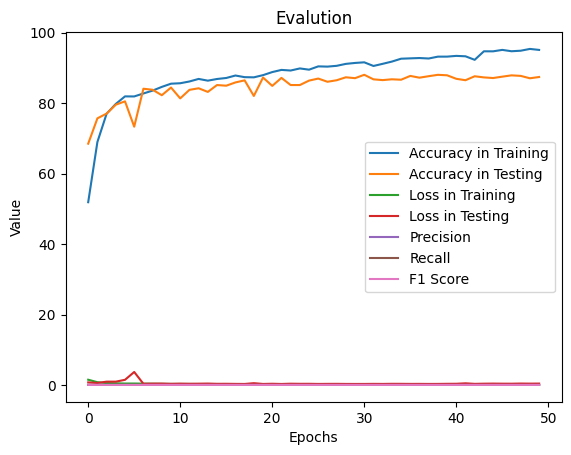

Precision: 0.09994799643754959
Recall: 0.09994799643754959
F1 Score: 0.09994799643754959


<Figure size 640x480 with 0 Axes>

In [37]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(acc_TRAIN, label="Accuracy in Training")
plt.plot(acc_TEST, label="Accuracy in Testing")
plt.plot(loss_TRAIN, label="Loss in Training")
plt.plot(loss_TEST, label="Loss in Testing")
plt.plot(precision_result, label="Precision")
plt.plot(recall_result, label="Recall")
plt.plot(f1_result, label="F1 Score")
# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Evalution')
# Display the plot
plt.legend()
plt.show()
plt.savefig('reports/evals_base_model_before_al.png')
print(f"Precision: {precision_result[-1]}")
print(f"Recall: {recall_result[-1]}")
print(f"F1 Score: {f1_result[-1]}")

In [38]:
torch.manual_seed(42)

In [39]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    model.eval()
    loss, acc = 0, 0

    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_pred = model(x)
            # Loss
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(torch.argmax(y_pred, dim=1), y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        "Model Name": model.__class__.__name__,
        "Model Loss": loss.item(),
        "Model Accuracy": acc,
    }, torch.argmax(y_pred, dim=1)

In [40]:
# Testing the model
FashionMNIST_model_results, y_pred = eval_model(model, FashionMNIST_test_data_loader, loss_fn, accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [41]:
FashionMNIST_model_results

{'Model Name': 'ResNet',
 'Model Loss': 0.47995617985725403,
 'Model Accuracy': 87.39017571884985}

In [42]:
len(next(iter(FashionMNIST_test_data_loader)))

2

# Evaluating Model Visually


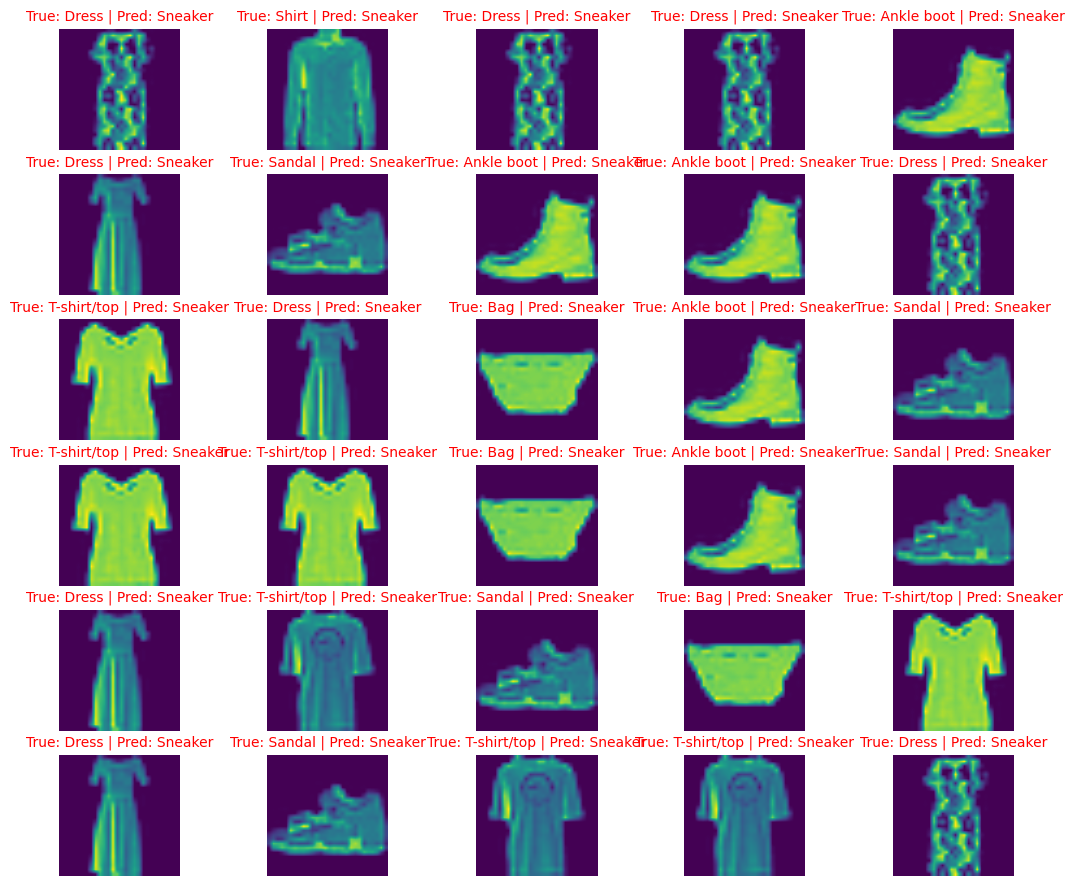

In [43]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(FashionMNIST_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

model.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index]
        pred_label = model(image.unsqueeze(0).repeat(1, 3, 1, 1).to(device)).argmax()
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image, interpolation="bilinear")
        if pred_label == label:
            plt.title(
                f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}",
                c="g",
                fontsize=10,
            )
        else:
            plt.title(
                f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}",
                c="r",
                fontsize=10,
            )
        plt.axis(False)
plt.savefig('reports/preds_base_model_before_al.png')

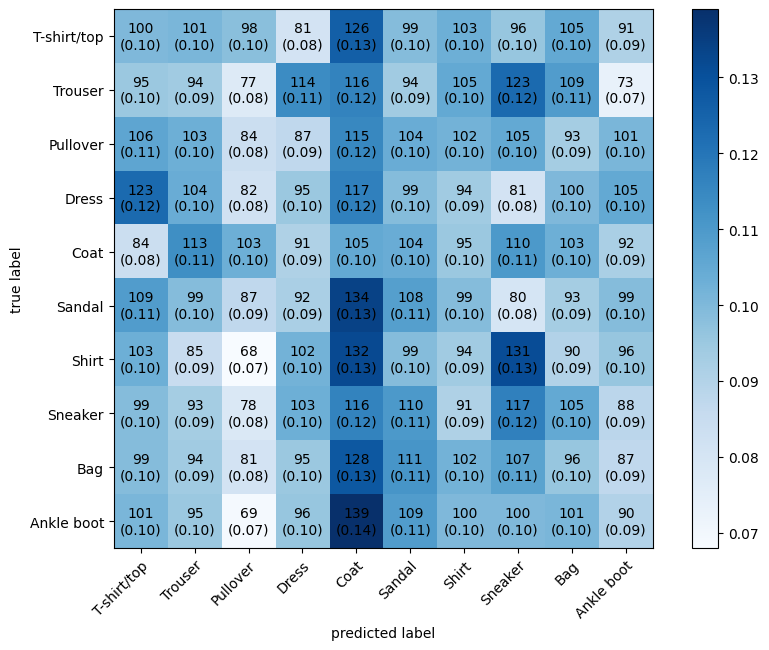

In [44]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(FashionMNIST_class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=torch.tensor(FashionMNIST_test_data.targets))
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=FashionMNIST_class_names,
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True
)
plt.savefig('reports/conf_mat_base_model_before_al.png')

# Saving the Model


In [45]:
# Create the models path
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)
# Create model save
MODEL_NAME = "base_model.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME
# Save the model
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/base_model.pth


# Load the Model


In [46]:
# Create a model instance
trained_model = models.resnet50().to(device)
trained_model.fc = nn.Linear(model.fc.in_features, 10)
trained_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
trained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
summary(trained_model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [48]:
trained_model = NeuralNetClassifier(
    trained_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=1,
    device=device,
)

# Active Learning


In [49]:
def active_learning(pool_x, pool_y, initial_x, initial_y, test_x, test_y, method, model, num_classes, class_names):
    learner = None
    cycles = 100
    acc = []
    precision_result = []
    recall_result = []
    f1_result = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=uncertainty_sampling,
        )
    elif method == "margin_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=margin_sampling,
        )
    elif method == "entropy_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=entropy_sampling,
        )
    elif method == "random_sampling":
        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
#             pool_x = pool_x.reshape(-1, 3, 32, 32)
            query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
            X_query = pool_x[query_idx]
            return query_idx, X_query
#         initial_x = initial_x.reshape(-1, 3, 32, 32)
#         initial_x = initial_x.astype(np.float32)
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=random_sampling,
        )
    else:
        print('Invalid Input')
    print(f"Starting Active Learning with {method} method")
    for cycle in range(cycles):
        print(f"\nCycle: {cycle+1}")
        query_idx, query_instance = learner.query(pool_x, n_instances=1)#n_instances=100
#         pool_x = pool_x.reshape(-1, 3, 32, 32)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        # remove queried instance from pool_x
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)
        model_accuracy = learner.score(np.concatenate((initial_x, pool_x), axis=0), np.concatenate((initial_y, pool_y), axis=0))
        print(f'Accuracy after query {cycle+1}: {model_accuracy:0.4f}')
        acc.append(model_accuracy)
        
        y_pred = learner.predict(test_x)
        # Initialize precision, recall, and F1 score metrics
        precision = Precision(task="multiclass", num_classes=num_classes)
        recall = Recall(task="multiclass", num_classes=num_classes)
        f1 = F1Score(task="multiclass", num_classes=num_classes)
        # Update the metrics with true and predicted labels
        precision.update(torch.tensor(y_pred), torch.tensor(test_y))
        recall.update(torch.tensor(y_pred), torch.tensor(test_y))
        f1.update(torch.tensor(y_pred), torch.tensor(test_y))
        # Compute the metrics
        precision_result.append(precision.compute())
        recall_result.append(recall.compute())
        f1_result.append(f1.compute())
        
    confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    confusion_matrix.update(torch.tensor(y_pred), torch.tensor(test_y))
    confusion_matrix.compute()
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.compute().numpy(), class_names=class_names, figsize=(10, 7), show_absolute=True, show_normed=True, colorbar=True)
    plt.savefig(f'reports/conf_mat_{method}_after_al.png')
    return acc, precision_result, recall_result, f1_result

In [50]:
x_pool = x_pool.unsqueeze(1).repeat(1, 3, 1, 1)
x_initial = x_initial.unsqueeze(1).repeat(1, 3, 1, 1)
x_test = x_test.unsqueeze(1).repeat(1, 3, 1, 1)

x_pool = x_pool.numpy()
x_initial = x_initial.numpy()
x_test = x_test.numpy()

x_pool = x_pool.astype(np.float32)
x_initial = x_initial.astype(np.float32)
x_test = x_test.astype(np.float32)

In [51]:
x_pool.shape, x_initial.shape, x_test.shape

((48000, 3, 28, 28), (12000, 3, 28, 28), (10000, 3, 28, 28))

In [52]:
acc_random_sampling, precision_result_random_sampling, recall_result_random_sampling, f1_result_random_sampling = active_learning(
    x_pool, y_pool, x_initial, y_initial, x_test, y_test, "random_sampling", trained_model, 10, FashionMNIST_class_names
)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0718  9.1133
      2        0.0440  9.0179
      3        0.0335  9.0479
      4        0.0397  9.0524
      5        0.0416  9.0755
      6        0.0340  9.0526
      7        0.0397  9.0314
      8        0.0300  9.0188
      9        0.0264  9.0258
     10        0.0308  9.0266
Starting Active Learning with random_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0262  9.0849
      2        0.0277  8.9979
      3        0.0246  9.0091
      4        0.0222  9.0215
      5        0.0242  9.0188
      6        0.0425  9.0725
      7        0.0249  9.1081
      8        0.0146  9.0783
      9        0.0164  9.0599
     10        0.0189  9.0681
Accuracy after query 1: 0.9093

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0226  9.0935
      2        0.0159  9.0414
  

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [ ]:
acc_uncertainty_sampling, precision_result_uncertainty_sampling, recall_result_uncertainty_sampling, f1_result_uncertainty_sampling = active_learning(
    x_pool, y_pool, x_initial, y_initial, x_test, y_test, "uncertainty_sampling", trained_model, 10, FashionMNIST_class_names
)

In [ ]:
acc_margin_sampling, precision_result_margin_sampling, recall_result_margin_sampling, f1_result_margin_sampling = active_learning(
    x_pool, y_pool, x_initial, y_initial, x_test, y_test, "margin_sampling", trained_model, 10, FashionMNIST_class_names
)

In [ ]:
acc_entropy_sampling, precision_result_entropy_sampling, recall_result_entropy_sampling, f1_result_entropy_sampling = active_learning(
    x_pool, y_pool, x_initial, y_initial, x_test, y_test, "entropy_sampling", trained_model, 10, FashionMNIST_class_names
)

# Plot All Metrics

# Accuracy

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(acc_random_sampling, label="acc_random_sampling")
plt.plot(acc_uncertainty_sampling, label="acc_uncertainty_sampling")
plt.plot(acc_margin_sampling, label="acc_margin_sampling")
plt.plot(acc_entropy_sampling, label="acc_entropy_sampling")

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Accuracy')
# Display the plot
plt.legend()
plt.show()
plt.savefig('reports/acc_base_model_after_al.png')

print(f"acc_random_sampling: {acc_random_sampling[-1]}")
print(f"acc_uncertainty_sampling: {acc_uncertainty_sampling[-1]}")
print(f"acc_margin_sampling: {acc_margin_sampling[-1]}")
print(f"acc_entropy_sampling: {acc_entropy_sampling[-1]}")

# Precision

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(precision_result_random_sampling, label="precision_result_random_sampling")
plt.plot(precision_result_uncertainty_sampling, label="precision_result_uncertainty_sampling")
plt.plot(precision_result_margin_sampling, label="precision_result_margin_sampling")
plt.plot(precision_result_entropy_sampling, label="precision_result_entropy_sampling")

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Precision')
# Display the plot
plt.legend()
plt.show()
plt.savefig('reports/prec_base_model_after_al.png')

print(f"precision_result_random_sampling: {precision_result_random_sampling[-1]}")
print(f"precision_result_uncertainty_sampling: {precision_result_uncertainty_sampling[-1]}")
print(f"precision_result_margin_sampling: {precision_result_margin_sampling[-1]}")
print(f"precision_result_entropy_sampling: {precision_result_entropy_sampling[-1]}")

# Recall

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(recall_result_random_sampling, label="recall_result_random_sampling")
plt.plot(recall_result_uncertainty_sampling, label="recall_result_uncertainty_sampling")
plt.plot(recall_result_margin_sampling, label="recall_result_margin_sampling")
plt.plot(recall_result_entropy_sampling, label="recall_result_entropy_sampling")

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Recall')
# Display the plot
plt.legend()
plt.show()
plt.savefig('reports/recall_base_model_after_al.png')

print(f"recall_result_random_sampling: {recall_result_random_sampling[-1]}")
print(f"recall_result_uncertainty_sampling: {recall_result_uncertainty_sampling[-1]}")
print(f"recall_result_margin_sampling: {recall_result_margin_sampling[-1]}")
print(f"recall_result_entropy_sampling: {recall_result_entropy_sampling[-1]}")

# F1 Score

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(f1_result_random_sampling, label="f1_result_random_sampling")
plt.plot(f1_result_uncertainty_sampling, label="f1_result_uncertainty_sampling")
plt.plot(f1_result_margin_sampling, label="f1_result_margin_sampling")
plt.plot(f1_result_entropy_sampling, label="f1_result_entropy_sampling")

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('F1 Score')
# Display the plot
plt.legend()
plt.show()
plt.savefig('reports/f1_base_model_after_al.png')

print(f"f1_result_random_sampling: {f1_result_random_sampling[-1]}")
print(f"f1_result_uncertainty_sampling: {f1_result_uncertainty_sampling[-1]}")
print(f"f1_result_margin_sampling: {f1_result_margin_sampling[-1]}")
print(f"f1_result_entropy_sampling: {f1_result_entropy_sampling[-1]}")